<a href="https://colab.research.google.com/github/AliNaqvi110/Stock-Price-Prediction-Using-LSTM/blob/main/Predicting_Stock_Prices_Using_Multivariate_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing dependencies
import tensorflow as tf
import numpy as np
np.random.seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from tensorflow.keras.layers import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [3]:
# Loading the dataset
url = '/content/BTCUSDT.csv'
df = pd.read_csv(url,parse_dates = True,index_col=0)
df.tail()

,Time,open,high,low,close,volume
date,,,,,,
2023-06-05,20:00:00,25630.00,25858.42,25509.98,25728.20,7034.47432
2023-06-06,00:00:00,25728.20,25801.09,25601.00,25730.83,5737.28976
2023-06-06,04:00:00,25730.83,25821.41,25706.18,25722.33,4562.45045
2023-06-06,08:00:00,25722.34,25797.00,25640.33,25686.64,4705.41680
2023-06-06,12:00:00,25686.64,25784.31,25351.02,25724.36,9558.97605


In [4]:
# Correlation matrix
df.corr()['close']

<ipython-input-4-37ecb080dab0>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['close']


open      0.999140
high      0.999555
low       0.999518
close     1.000000
volume   -0.514976
Name: close, dtype: float64

In [5]:
print((df['volume'] == 0).any())

False


In [6]:
print(df.describe().volume) 
df.drop(df[df['volume']==0].index, inplace = True) #Dropping rows with volume value 0

count      5000.000000
mean      20567.522090
std       22441.310791
min           5.887034
25%        6600.363932
50%       11807.125720
75%       26613.422357
max      284711.694213
Name: volume, dtype: float64


In [7]:
print((df['close'] == 0).any())

False


In [8]:
print((df['open'] == 0).any())

False


In [9]:
print((df['high'] == 0).any())

False


In [10]:
print((df['low'] == 0).any())

False


In [11]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [12]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [13]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat

In [14]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [15]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

In [16]:
# Extracting the series
series = df[['close','high','volume']] # Picking the series with high correlation
print(series.shape)
print(series.tail())

(5000, 3)
               close      high      volume
date                                      
2023-06-05  25728.20  25858.42  7034.47432
2023-06-06  25730.83  25801.09  5737.28976
2023-06-06  25722.33  25821.41  4562.45045
2023-06-06  25686.64  25797.00  4705.41680
2023-06-06  25724.36  25784.31  9558.97605


In [17]:
# check min and max dates
print("Min Date is ", series.index.min())
print("Max Date is ", series.index.max())


Min Date is  2021-02-23 00:00:00
Max Date is  2023-06-06 00:00:00


In [18]:
# Train Val Test Split
train_start = dt.date(2021,2,23)
train_end = dt.date(2022,6,30)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2022,7,1)
val_end = dt.date(2022,12,31)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2023,1,1)
test_end = dt.date(2023,6,6)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

(2956, 3) (1104, 3) (940, 3)


In [19]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(2956, 3) (1104, 3) (940, 3)


In [20]:
timesteps = 50
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 250

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 219: early stopping


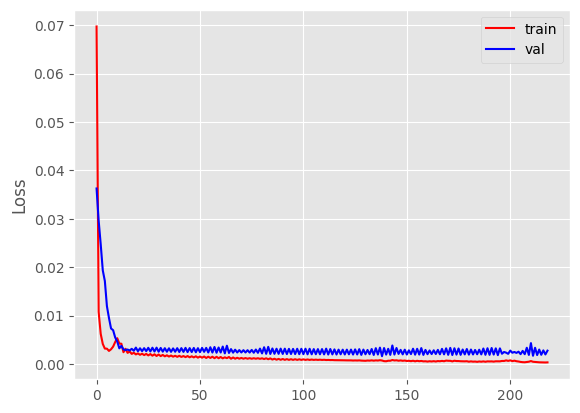

In [ ]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

28/28 [==============================] - 1s 28ms/step
MSE = 0.0012650019970450784
RMSE = 0.035566866562083854
R-Squared Score = 0.6609099503522002


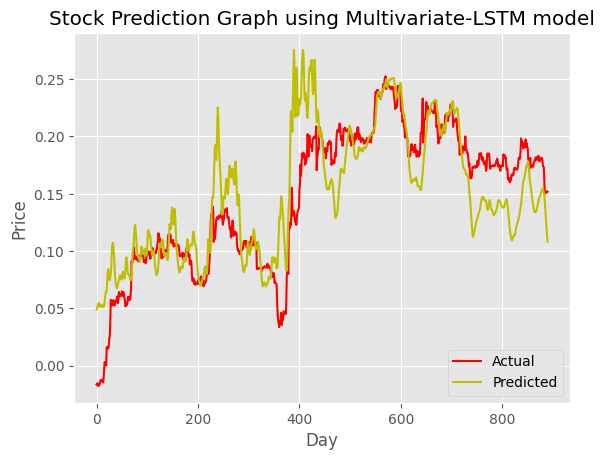

In [ ]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

In [ ]:
# Save a model
model.save('MV3-LSTM_50_[40,35]_1e-3_64.h5')
#del model # Deletes the model
# Load a model
model = load_model('MV3-LSTM_50_[40,35]_1e-3_64.h5')

In [ ]:
# Hyperparameters
timesteps = 50
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 50

In [ ]:
# Extracting the series
series = df[['close','high','volume']] # Picking the multivariate series 
print(series.shape)
print(series.tail())

(5000, 3)
               close      high      volume
date                                      
2023-06-05  25728.20  25858.42  7034.47432
2023-06-06  25730.83  25801.09  5737.28976
2023-06-06  25722.33  25821.41  4562.45045
2023-06-06  25686.64  25797.00  4705.41680
2023-06-06  25724.36  25784.31  9558.97605


In [ ]:
# Normalisation
sc = MinMaxScaler()
series = sc.fit_transform(series[:5400])
series

array([[0.58078531, 0.64320282, 0.18947483],
       [0.62309848, 0.63517266, 0.1281455 ],
       [0.56474707, 0.62854729, 0.06301056],
       ...,
       [0.18949999, 0.18800361, 0.01600446],
       [0.18882363, 0.18754457, 0.01650662],
       [0.18953847, 0.18730593, 0.03355425]])

In [ ]:
#Splitting the data for initial model creation
splits = 5
split_size = 600
train = series[:3*split_size]
test = series[3*split_size:4*split_size]

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


18/18 [==============================] - 1s 20ms/step
Split 1
MSE = 0.0022098704638564616
RMSE = 0.04700925934171332
R-Squared Score = 0.3946225940336989


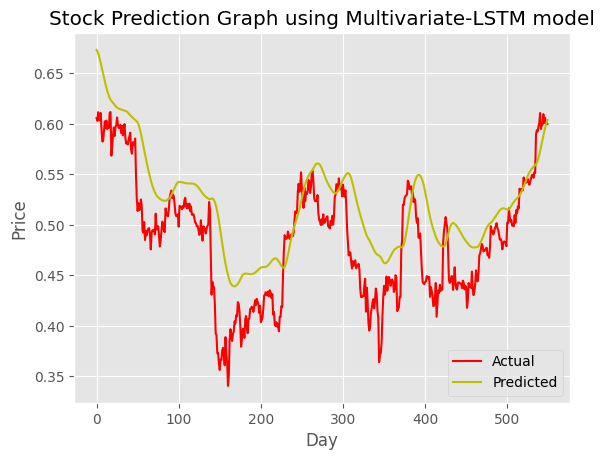

In [ ]:
cross_val_results = list()
train_loss = pd.DataFrame()
val_loss = pd.DataFrame()
model,train_error,val_error = fit_model(train,test,timesteps,hl,lr,batch_size,num_epochs)
train_loss['Split1'] = train_error
val_loss['Split1'] = val_error
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 1")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,0])
model.save("MV3-LSTM-Split1.h5")

18/18 [==============================] - 0s 20ms/step
Split 2
MSE = 0.007263791327033583
RMSE = 0.08522787881341165
R-Squared Score = 0.6511885262593669


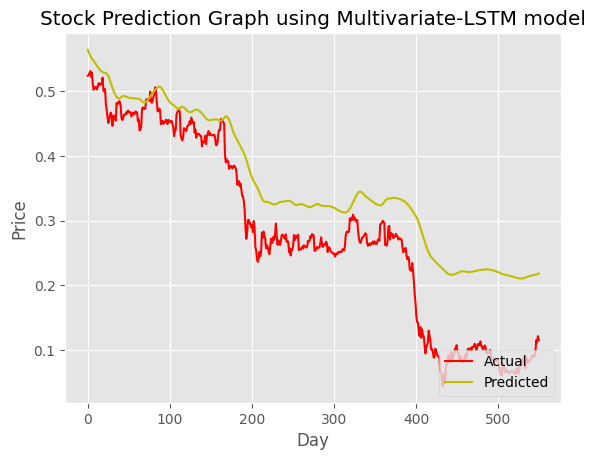

In [ ]:

train = series[:4*split_size]
test = series[4*split_size:5*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split2"] = history.history['loss']
val_loss["Split2"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 2")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("MV3-LSTM-Split2.h5")

In [ ]:
train = series[:5*split_size]
test = series[5*split_size:6*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split3"] = history.history['loss']
val_loss["Split3"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 3")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("MV3-LSTM-Split3.h5")

KeyboardInterrupt: ignored

18/18 [==============================] - 1s 31ms/step
Split 4
MSE = 0.0025194298091456725
RMSE = 0.05019392203390439
R-Squared Score = -0.8901533842601874


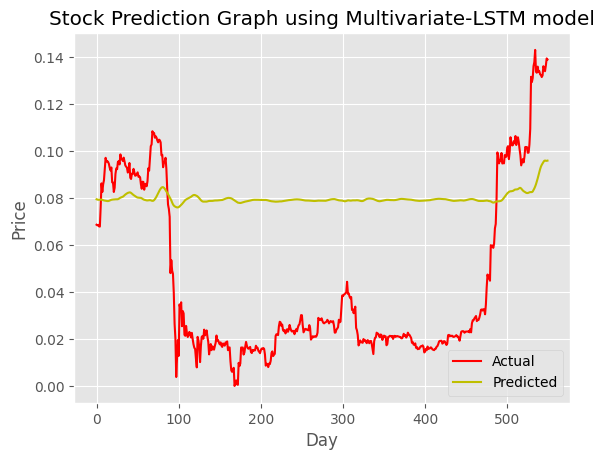

In [ ]:
train = series[:6*split_size]
test = series[6*split_size:7*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split4"] = history.history['loss']
val_loss["Split4"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 4")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("MV3-LSTM-Split4.h5")

18/18 [==============================] - 0s 20ms/step
Split 5
MSE = 0.0004667008430106846
RMSE = 0.02160326000886636
R-Squared Score = 0.8491591122306261


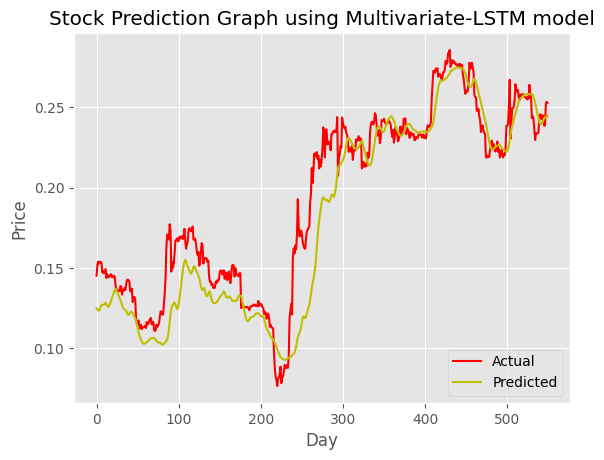

In [ ]:
train = series[:7*split_size]
test = series[7*split_size:8*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split5"] = history.history['loss']
val_loss["Split5"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 5")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("MV3-LSTM-Split5.h5")

In [ ]:
CV_results = pd.DataFrame(cross_val_results,columns=['MSE','RMSE','R2_Score','Train_Time'])
print("Avg. MSE = {}".format(CV_results['MSE'].mean()))
print("Avg. RMSE = {}".format(CV_results['RMSE'].mean()))
print("Avg. R2-score = {}".format(CV_results['R2_Score'].mean()))

Avg. MSE = 0.0036040307368667276
Avg. RMSE = 0.055720429999854694
Avg. R2-score = -0.5644858964398296


## **Testing Model**

In [21]:
# load the model
model = load_model('/content/MV3-LSTM_50_[40,35]_1e-3_64.h5')

In [22]:
# Normalisation
scaler = MinMaxScaler()
test = scaler.fit_transform(test_data)
print(test.shape)

(940, 3)


28/28 [==============================] - 4s 21ms/step
MSE = 0.0012314194095607032
RMSE = 0.03509158602230317
R-Squared Score = 0.9735407439930623


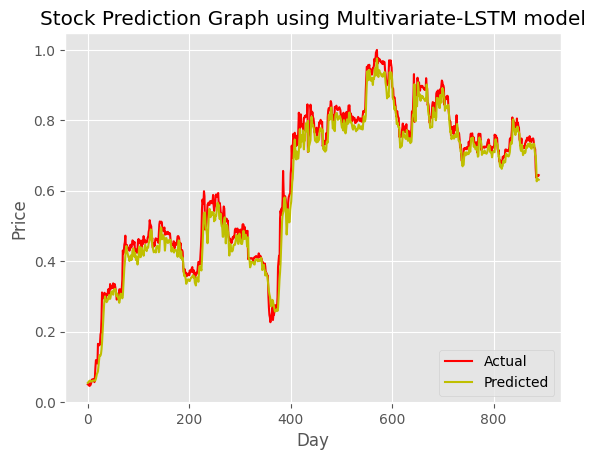

In [23]:
timesteps = 50
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

In [24]:
forecast = pd.DataFrame({'Actual': true, 'Future Forecast': predicted.reshape(-1)})
forecast.head()

,Actual,Future Forecast
0,0.049927,0.054454
1,0.051997,0.056153
2,0.053763,0.057879
3,0.045677,0.059725
4,0.047600,0.060703


In [25]:
print(predicted.shape)

(890, 1)


In [26]:
# read data
data = pd.read_csv('/content/ohlcv.csv')
data.head()

,Date,H,L,O,C,V
0,1993-01-29,25.352045,25.225915,25.352045,25.334026,1003200.0
1,1993-02-01,25.514210,25.352043,25.352043,25.514210,480500.0
2,1993-02-02,25.586283,25.442134,25.496190,25.568264,201300.0
3,1993-02-03,25.856560,25.586282,25.604300,25.838541,529400.0
4,1993-02-04,26.000711,25.640341,25.928637,25.946655,531500.0


In [27]:
my_data = data[['C', 'H', 'V']]
my_data = my_data.rename(columns={'C': 'close', 'H': 'high', 'V': 'volume'})
my_data.head()

,close,high,volume
0,25.334026,25.352045,1003200.0
1,25.514210,25.514210,480500.0
2,25.568264,25.586283,201300.0
3,25.838541,25.856560,529400.0
4,25.946655,26.000711,531500.0


In [54]:
# Normalisation
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(my_data)
# Access the minimum and maximum values
min_value = scaler.data_min_
max_value = scaler.data_max_
Original_Range = max_value - min_value
original_close = Original_Range[0]
min_close = min_value[0]
max_close = max_value[0]
print(scaled_data.shape)

(7508, 3)


In [55]:
print(original_close)
print(min_close)
print(max_close)

447.2145938873291
25.0277156829834
472.2423095703125


In [33]:
print(type(scaled_data))

<class 'numpy.ndarray'>


234/234 [==============================] - 7s 31ms/step
MSE = 0.0010146688338421108
RMSE = 0.03185386685854813
R-Squared Score = 0.9807049378948124


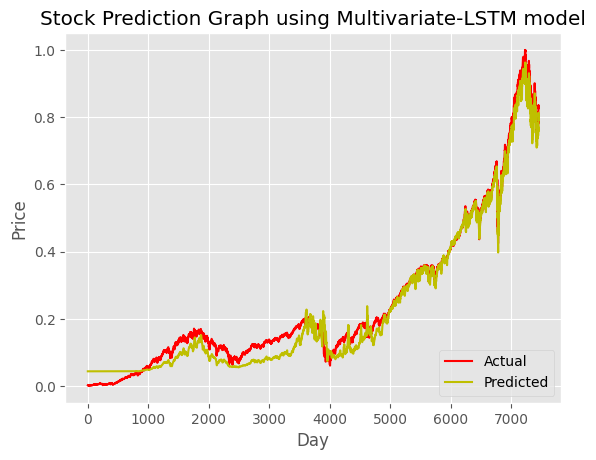

In [34]:
timesteps = 50
mse, rmse, r2_value,true,predicted = evaluate_model(model,scaled_data,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

In [35]:
forecast = pd.DataFrame({'Actual':true, 'Future Forecast': predicted.reshape(-1)})
forecast.head()

,Actual,Future Forecast
0,0.002329,0.043725
1,0.002248,0.043725
2,0.002248,0.043725
3,0.002248,0.043725
4,0.002005,0.043725


In [43]:
print(len(forecast['Future Forecast'])-1)

7457


In [42]:
forecast.shape

(7458, 2)

In [56]:
# Inverse transformations
actual_future_forecast = []
actual_true = []
for i in range(len(forecast['Future Forecast'])-1):
  actual_future_forecast.append((forecast['Future Forecast'][i] * original_close) + min_close)
  actual_true.append((forecast['Actual'][i] * original_close) + min_close)

actual_forecast = pd.DataFrame({'Actual': actual_true, 'Future Forecast': actual_future_forecast})
actual_forecast.head()

,Actual,Future Forecast
0,26.069197,44.582307
1,26.032984,44.582307
2,26.032984,44.582307
3,26.032984,44.582307
4,25.924379,44.582307
